In [109]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from skimage.color import gray2rgb

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from torchviz import make_dot

In [110]:
def load_nuclei_data(data_path):
    images = []
    masks = []
    root = data_path
    for subdir in tqdm(os.listdir(root)):
        subfolder = os.path.join(root,subdir)
        if os.path.isdir(subfolder):
#             print(subdir)
            for subsubfolder_name in os.listdir(subfolder):
                if subsubfolder_name == 'images':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        for file in files:
                            if file.endswith('.png'):
                                images.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                if subsubfolder_name == 'masks':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        mask = []
                        for file in files:
                            if file.endswith('.png'):
                                mask.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                        masks.append(mask)
    return images, masks
                    

In [111]:
train_images, train_masks = load_nuclei_data('./data/nuclei/train')
test_images,_ = load_nuclei_data('./data/nuclei/test')

print("there are %d train images"%(len(train_images)))
print("there are %d test images"%(len(test_images)))


there are 670 train images
there are 65 test images


## Note:
1. from print, we know that train images are not the same size, 4 channels-rgb+alpha. 
2. mask images are the same size as train images.

## TODO：
1. let's firstly try the simplest solution, resize them all to 256x256; **done**
2. mask could be summed together; **done**
2. better solution could be crop 256x256 from images;

In [112]:
# print("there are %d train images"%(len(train_images)))
# for image in train_images:
#     print(image.shape)

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
X = np.array(X, np.float32)
X = X[:,:,:,:-1]# we don't need this alpha channel, right?

# thresholding to get the mask
Y = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
k = 0
for masks in tqdm(train_masks):
    ys = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
    ys = np.array(ys, np.float32)
    ys = ys.mean(axis=0)
    Y[k] = ys
    k += 1


In [113]:
Z = np.zeros([len(test_images),size[0],size[1],3])
print(Z.shape)
k = 0
## test image contains gray?, rgba, rgb...
for image in tqdm(test_images):
    if image.shape[2] == 1:
        image = gray2rgb(image)
        image = np.array(image, np.float32)
        image = resize(image, size, mode='constant', anti_aliasing=True)
    else:
        image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
    if image.shape[2] == 4:
        Z[k] = image[:,:,:-1]
    else:
        Z[k] = image
    k+=1

(65, 256, 256, 3)


(670, 256, 256, 3)


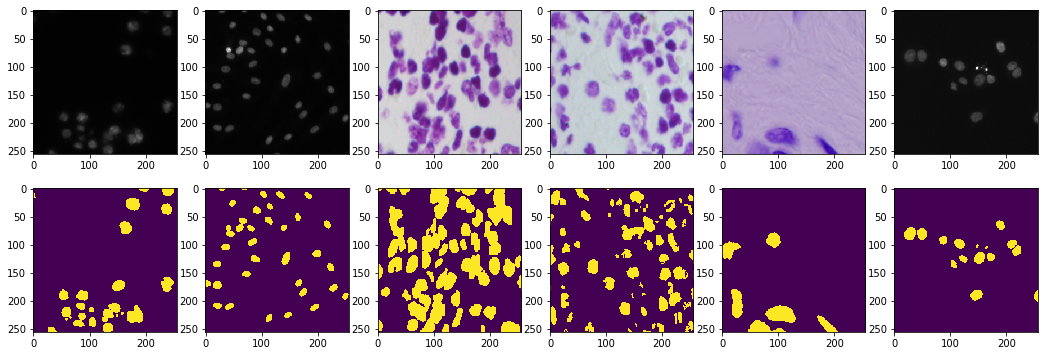

In [114]:
plt.rcParams['figure.figsize'] = [18, 6]

print(X.shape)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y[i])
#     print(Y[i][Y[i] == 1])
#     break
plt.show()

In [121]:
# split total training data
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [round(0.8*len(X))])

batch_size = 25

print(X.shape)
print(Y.shape)

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) 
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), 
                      batch_size=batch_size, shuffle=True)

data, label = next(iter(data_tr))
print(label.shape)

(670, 256, 256, 3)
(670, 256, 256)
torch.Size([25, 1, 256, 256])


## now, ready for sematic segmentation using DL

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [117]:
def bce_loss(y_real, y_pred):
#     return torch.mean(-y_real*y_pred+torch.log(1 + torch.exp(y_pred)))
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

def train(model, opt, loss_fn, epochs, data_tr, data_val,verbose=False):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        if verbose == False:
            clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [118]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))()) for X_batch, _ in data]
    return np.array(Y_pred)

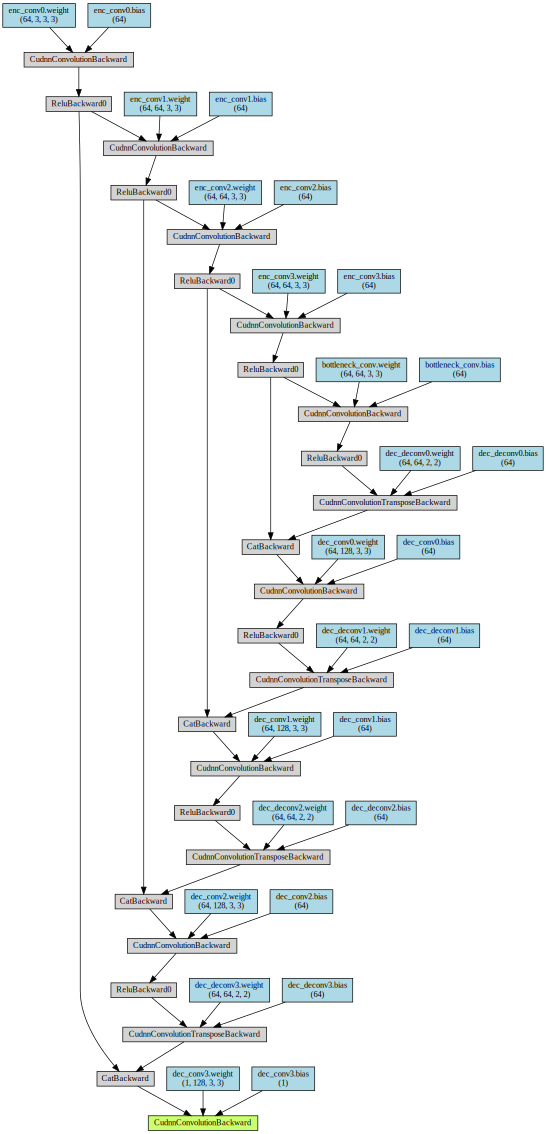

In [126]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1, stride=1) # 256
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 256->128
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 128->64
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 64->32

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1, stride=2) #32->16

        # decoder (upsampling)
        self.dec_deconv0 = nn.ConvTranspose2d(64,64, 2, stride=2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv1 = nn.ConvTranspose2d(64,64, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv3 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        conv0 = F.relu(self.enc_conv0(x)) ## save this, concatenate later
        conv1 = F.relu(self.enc_conv1(conv0))
        conv2 = F.relu(self.enc_conv2(conv1))
        conv3 = F.relu(self.enc_conv3(conv2))

        # bottleneck
        b = F.relu(self.bottleneck_conv(conv3))

        # decoder
        up0 = self.dec_deconv0(b)
        up0concate = torch.cat((up0,conv3),1)
        d0 = F.relu(self.dec_conv0(up0concate))
        
        up1 = self.dec_deconv1(d0)
        up1concate = torch.cat([up1,conv2],1)
        d1 = F.relu(self.dec_conv1(up1concate))
        
        up2 = self.dec_deconv2(d1)
        up2concate = torch.cat([up2,conv1],1)
        d2 = F.relu(self.dec_conv2(up2concate))
                    
        up3 = self.dec_deconv3(d2)
        up3concate = torch.cat([up3,conv0],1)
        d3 = self.dec_conv3(up3concate)  # no activation
        
        return d3

make_dot(model(torch.randn(20, 3, 256, 256).cuda()), params=dict(model.named_parameters()))

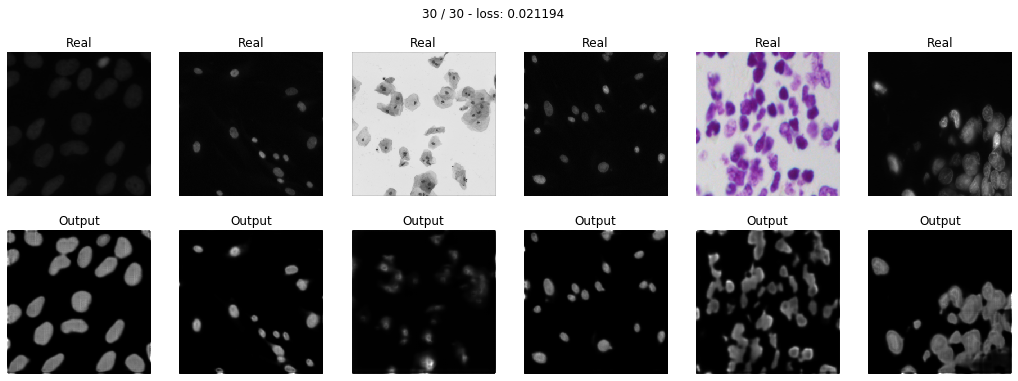

In [128]:
model = UNet2().to(device)

train(model, optim.Adam(model.parameters(), 1e-3), bce_loss, 30, data_tr, data_val)